<div style="text-align: center;">
<strong>Machine Learning for Scientific Computing and Numerical Analysis - PC 7</strong>
</div>
<div style="text-align: center;">
<strong>RB-Galerkin for the viscous Burgers' equation</strong>
</div>
<div style="text-align: center;">
<p>Loïc Gouarin, Samuel Kokh, Hadrien Montanelli</p>
</div>
<div style="text-align: center;">
<i>2024 - 2025</i>
</div>

# 1 Imports and helper functions

In [44]:
from math import pi
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import time

def compute_burgers_reference(N, eps, T, u0):
    """Solve viscous Burgers' equation on [-1,1] with periodic boundary conditions with a Fourier spectral method and ETDRK4."""
    
    # Grid and initial condition:
    x = np.linspace(-1, 1, N, endpoint=False)
    v = np.fft.fft(u0(x))
    
    # Precompute constants:
    h = 1e-2
    k = np.fft.fftfreq(N, d=1/N) * pi 
    L = -eps * k**2  
    E = np.exp(h * L)
    E2 = np.exp(h * L / 2)
    M = 16
    r = np.exp(1j * pi * (np.arange(1, M + 1) - 0.5) / M)
    LR = h * L[:, None] + r[None, :]
    Q = h * np.real(np.mean((np.exp(LR / 2) - 1) / LR, axis=1))
    f1 = h * np.real(np.mean((-4 - LR + np.exp(LR) * (4 - 3 * LR + LR**2)) / LR**3, axis=1))
    f2 = h * np.real(np.mean((4 + 2 * LR + np.exp(LR) * (-4 + 2 * LR)) / LR**3, axis=1))
    f3 = h * np.real(np.mean((-4 - 3 * LR - LR**2 + np.exp(LR) * (4 - LR)) / LR**3, axis=1))
    g = -0.5j * k
    
    # Time-stepping with exponential integrator:
    t = 0
    f = lambda v: v**2
    while t < T:
        Nv = g * np.fft.fft(f(np.real(np.fft.ifft(v))))
        a = E2 * v + Q * Nv
        Na = g * np.fft.fft(f(np.real(np.fft.ifft(a))))
        b = E2 * v + Q * Na
        Nb = g * np.fft.fft(f(np.real(np.fft.ifft(b))))
        c = E2 * a + Q * (2 * Nb - Nv)
        Nc = g * np.fft.fft(f(np.real(np.fft.ifft(c))))
        v = E * v + Nv * f1 + (Na + Nb) * f2 + Nc * f3
        t += h
    
    u = np.real(np.fft.ifft(v))
    
    return u

# 2 RB-Galerkin for viscous Burgers' equations

We consider the one-dimensional viscous Burgers' equation with periodic boundary conditions:

\begin{align}
& u_t(t,x;\mu) + \frac{1}{2}(u^2(t,x;\mu))_x = \epsilon u_{xx}(t,x;\mu), && t\in[0,T], \quad x\in[-1,1], \\
& u(t,-1;\mu) = u(t,1;\mu), && t\in[0,T], \\
& u_x(t,-1;\mu) = u_x(t,1;\mu), && t\in[0,T], \\
& u(0,x;\mu) = u_0(x;\mu), && x\in[-1,1].
\end{align}

We will take $T=1$ and the following intial condition,

$$
u_0(x;\mu) = e^{-100(x - \mu)^2}.
$$

The reference solution $u(T,x;\mu)$ is computed from `compute_burgers_reference`, which combines a Fourier spectral method in space with an exponential integrator in time, a generalization of `epxm` for nonlinear PDEs; see, e.g., <a href="https://en.wikipedia.org/wiki/Exponential_integrator" style="color: blue">this</a> and <a href="https://arxiv.org/pdf/1604.08900" style="color: blue">this</a>.

**Note: In this problem, the parameter $\mu$ comes from the initial condition $u_0(\cdot;\mu)$. The diffusion constant $\epsilon$ is fixed.**

We discretize space with

$$
x_j = -1 + jh, \quad h=2/(N_h+1), \quad 0\leq j\leq N_h+1.
$$

We have the following $N_h+1$ basis functions on $[-1,1]$. Note the extra dotted basis function $\phi_0$, which accounts for periodic boundary conditions. The $N_h+1$ degrees of freedom are the values at the $N_h$ interior grid points and the value at left boundary point $x_0=-1$.

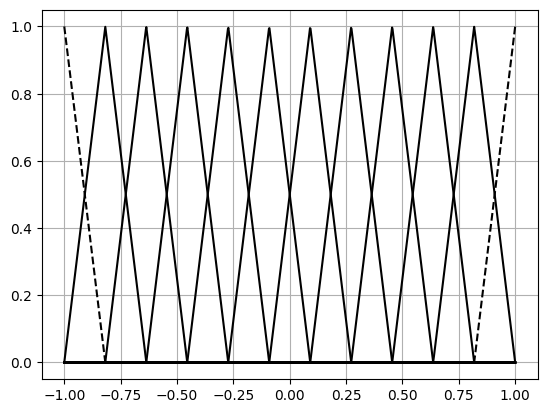

In [45]:
# Computation grid and basis functions:
N_h = 10
h = 2/(N_h + 1)
x_h = np.linspace(-1, 1, N_h + 2)
phi = lambda x: (1 - np.abs(x)) * (np.abs(x) <= 1)
Phi = lambda i, x: np.where(i > 0, phi((x - x_h[i])/h), phi((x - x_h[0])/h) + phi((x - x_h[N_h + 1])/h))

# Plot basis functions on a finer grid:
N_eval = 1000
x_eval = np.linspace(-1, 1, N_eval + 1)
plt.figure()
for j in range(N_h + 1):
    if j == 0:
        plt.plot(x_eval, Phi(j, x_eval), '--k')
    else:
        plt.plot(x_eval, Phi(j, x_eval), 'k')
plt.grid();

## 2.1 Galerkin ODE system

We seek a finite element approximation of $u$

$$
u_h(t,x;\mu) = \sum_{j=0}^{N_h} u_h^j(t;\mu)\phi_j(x), \qquad u_h^j(t;\mu) = u_h(t,x_j;\mu),
$$

which verifies the Galerkin variational problem

$$
\int_{-1}^1 \partial_t u_h(t,x;\mu)\phi_i(x)dx - \frac{1}{2} \int_{-1}^1 u_h^2(t,x;\mu)\phi_i'(x)dx = -\epsilon\int_{-1}^1 \partial_x u_h(t,x;\mu)\phi_i'(x)dx, \qquad 0\leq i\leq N_h.
$$

By substituting the expression for $u_h$ and approximating

$$
u_h^2(t,x;\mu) \approx \sum_{j=0}^{N_h} (u_h^j(t;\mu))^2\phi_j(x),
$$

we obtain the following ODE system,

$$
\sum_{j=0}^{N_h} \partial_t u_h^j(t;\mu) \int_{-1}^1 \phi_i(x)\phi_j(x)dx - \frac{1}{2} \int_{-1}^1 (u_h^j(t,x;\mu))^2\phi_i'(x)\phi_j(x)dx = -\epsilon\sum_{j=0}^{N_h}u_j(t;\mu)\int_{-1}^1 \phi_i'(x)\phi_j'(x)dx, \qquad 0\leq i\leq N_h.
$$ 

We set

$$
(A_h)_{ij} = \int_{-1}^1 \phi_i'(x)\phi_j'(x)dx, \qquad (K_h)_{ij} = -\int_{-1}^1 \phi_i'(x)\phi_j(x)dx, \qquad (M_h)_{ij} = \int_{-1}^1 \phi_i(x)\phi_j(x)dx.
$$

Then the $(N_h+1)\times(N_h+1)$ Galerkin ODE system reads

$$
M_h U_h'(t;\mu) = -\frac{1}{2} K_h(\mu) U_h^2(t;\mu) - \epsilon A_h(\mu) U_h(t;\mu),
$$

with unknown $U_h(t;\mu) = (u_h^0(t;\mu),\ldots,u_h^{N_h}(t;\mu))^T$ and Hadmard product $U_h^2 = U_h\odot U_h$. Using **forward** Euler in time with time-step $k$ and $U_h(t_n=nk;\mu)\approx U^n(\mu)$, we get

$$
M_h U^{n+1}(\mu) = M_h U^n(\mu) - \frac{k}{2}K_h(U^n(\mu))^2 - k\epsilon A_hU^n(\mu).
$$

### Exercise (theory)

{exercise}
Show that the $(N_h+1)\times(N_h+1)$ matrices $A_h$ and $M_h$ read

$$
A_h = \frac{1}{h}\begin{pmatrix}
\phantom{-}2 & -1 & & & -1 \\
-1 & \phantom{-}2 & -1 \\
& \ddots & \ddots & \ddots \\
& & -1 & \phantom{-}2 & -1 \\
-1 & & & -1 & \phantom{-}2
\end{pmatrix}, \qquad
M_h = \frac{h}{3}\begin{pmatrix}
2 & 0.5 & & & 0.5 \\
0.5 & 2 & 0.5\\
& \ddots & \ddots & \ddots \\
& & 0.5 & 2 & 0.5 \\
0.5 & & & 0.5 & 2
\end{pmatrix}.
$$

Note the entries in the corners of the matrices. Find an expression for the $(N_h+1)\times(N_h+1)$ matrix $K_h$. (It will have some nonzero corner entries, too.)

# Calculation of $A_h$, $M_h$ and $K_h$

We have  
$$
(A_h)_{ij} = \int_{-1}^1 \phi_i'(x)\,\phi_j'(x)\,dx,\quad
(K_h)_{ij} = -\int_{-1}^1 \phi_i'(x)\,\phi_j(x)\,dx,\quad
(M_h)_{ij} = \int_{-1}^1 \phi_i(x)\,\phi_j(x)\,dx
$$

## 1. $A_h$
The matrix is nonzero only when $i$ and $j$ are equal or differ by 1 due to the construction of $\phi$.

### Case $i=j$
$\phi_i$ is nonzero on $[x_{i-1},x_i]$ and $[x_i,x_{i+1}]$  
- On $[x_{i-1},x_i]$, we have:  
  $$\phi_i'(x) = \frac{1}{h}$$
- On $[x_i,x_{i+1}]$, we have:  
  $$\phi_i'(x) = -\frac{1}{h}$$

Therefore,
$$
(A_h)_{ii}
= \int_{x_{i-1}}^{x_i}\left(\frac{1}{h}\right)^2 dx
+ \int_{x_i}^{x_{i+1}}\left(-\frac{1}{h}\right)^2 dx
= \frac{2}{h}
$$

### Case $j=i\pm 1$
For $j=i+1$, the common support is $[x_i,x_{i+1}]$, and we have:  
- $\phi_i'(x) = -\frac{1}{h}$  
- $\phi_{i+1}'(x) = \frac{1}{h}$  

Thus,
$$
(A_h)_{i,i+1}
= \int_{x_i}^{x_{i+1}}\left(-\frac{1}{h}\right)\left(\frac{1}{h}\right)\,dx
= -\frac{1}{h}
$$

By the same reasoning, $(A_h)_{i,i-1} = -\frac{1}{h}$.  
Moreover, by periodicity of $\phi$, we find $(A_h)_{0,N_h}$ and $(A_h)_{N_h,0}$ also equal $-\frac{1}{h}$.

We thus have:
$$
A_h = \frac{1}{h}
\begin{pmatrix}
2 & -1 &        &        & -1 \\
-1 & 2  & -1     &        &    \\
   & \ddots & \ddots & \ddots &    \\
   &        & -1     & 2      & -1 \\
-1 &        &        & -1     & 2
\end{pmatrix}
$$

## 2. $M_h$
Again, the matrix is nonzero only when $i$ and $j$ are equal or differ by 1.

### Case $i=j$
- **On $[x_{i-1},x_i]$:**  
  $$\phi_i(x) = \frac{x - x_{i-1}}{h}$$  
  so
  $$
  I_1 = \int_{x_{i-1}}^{x_i} \left(\frac{x - x_{i-1}}{h}\right)^2 dx
      = \frac{1}{h^2}\,\frac{h^3}{3}
      = \frac{h}{3}
  $$
- **On $[x_i,x_{i+1}]$:**  
  $$\phi_i(x) = \frac{x_{i+1} - x}{h}$$  
  similarly
  $$
  I_2 = \int_{x_i}^{x_{i+1}} \left(\frac{x_{i+1} - x}{h}\right)^2 dx
      = \frac{h}{3}
  $$

Hence,
$$
(M_h)_{ii} = I_1 + I_2 = \frac{2h}{3}
$$

### Case $j=i\pm 1$
For $j=i+1$, both $\phi_i$ and $\phi_{i+1}$ are nonzero on $[x_i,x_{i+1}]$, so
$$
(M_h)_{i,i+1}
= \int_{x_i}^{x_{i+1}} \frac{(x_{i+1}-x)(x-x_i)}{h^2}\,dx
$$
Translating $x$ by $x_i$ gives
$$
(M_h)_{i,i+1}
= \frac{1}{h^2}\int_0^h y\,(h-y)\,dy
= \frac{1}{h^2}\Bigl(h\cdot\frac{h^2}{2}-\frac{h^3}{3}\Bigr)
= \frac{h}{6}
$$

By symmetry, $(M_h)_{i,i-1} = \frac{h}{6}$, and by periodicity,
$(M_h)_{0,N_h} = (M_h)_{N_h,0} = \frac{h}{6}$

Thus,
$$
M_h = \frac{h}{3}
\begin{pmatrix}
2   & 0.5 &       &      & 0.5 \\
0.5 & 2   & 0.5   &      &     \\
    & \ddots & \ddots & \ddots &     \\
    &      & 0.5   & 2    & 0.5 \\
0.5 &      &       & 0.5  & 2
\end{pmatrix}
$$

## 3. Calculation of the matrix $K_h$

### Case $j=i$
On both $[x_{i-1},x_i]$ and $[x_i,x_{i+1}]$, one of the factors vanishes, so
$$
(K_h)_{ii} = 0
$$

### Case $j=i+1$
On $[x_i,x_{i+1}]$:
- $\phi_i'(x) = -\frac{1}{h}$,  
- $\phi_{i+1}(x) = \frac{x - x_i}{h}$

Therefore,
$$
(K_h)_{i,i+1}
= -\int_{x_i}^{x_{i+1}} \left(-\frac{1}{h}\right)\frac{x-x_i}{h}\,dx
= \frac{1}{h^2}\,\frac{h^2}{2}
= \frac{1}{2}
$$

### Case $j=i-1$
On $[x_{i-1},x_i]$:
- $\phi_i'(x) = \frac{1}{h}$,  
- $\phi_{i-1}(x) = \frac{x_i - x}{h}$

Hence,
$$
(K_h)_{i,i-1}
= -\int_{x_{i-1}}^{x_i} \frac{1}{h}\,\frac{x_i-x}{h}\,dx
= -\frac{1}{2}
$$

By periodicity,
$$
(K_h)_{0,N_h} = -\frac{1}{2},\quad
(K_h)_{N_h,0} = \frac{1}{2}
$$

Thus,
$$
K_h = \frac{1}{2}
\begin{pmatrix}
0  & 1   & 0 & \cdots & 0  & -1 \\
-1 & 0   & 1 & \cdots & 0  & 0  \\
0  & -1  & 0 & \ddots &    & \vdots \\
\vdots & \ddots & \ddots & \ddots & 1 & 0 \\
0  & 0   & \cdots & -1 & 0 & 1 \\
1  & 0   & \cdots & 0  & -1 & 0 
\end{pmatrix}
$$

### Exercise

{exercise}
Complete the missing parts. Why do we choose the time-step as $k=\epsilon^{-1}h^2/6$?

The $L^\infty$-error should be between $10^{-3}$ and $10^{-4}$.

In [3]:
def assemble_matrices(N_h):
    """
    Assemble the stiffness matrix A_h, advection matrix K_h and mass matrix M_h for the Galerkin method.

    Parameters
    ----------
    N_h : int
        The number of interior grid points.
        
    Returns
    -------
    A_h : scipy.sparse.csc_matrix
        The stiffness matrix of size (N_h+1, N_h+1).
    K_h : scipy.sparse.csc_matrix
        The advection matrix of size (N_h+1, N_h+1).
    M_h : scipy.sparse.csc_matrix
        The mass matrix of size (N_h+1, N_h+1).
    """

    # Grid size:
    h = 2/(N_h + 1)

    # Advection matrix:
    diag_K   = np.zeros(N_h+1)
    sous_diag_K    = np.full(N_h, -0.5)
    sur_diag_K  = np.full(N_h,  0.5)
    K_h = diags([diag_K, sous_diag_K, sur_diag_K], [0, -1, 1],shape=(N_h+1, N_h+1), format='csc')

    K_1 = diags([-0.5], [N_h], shape=(N_h+1, N_h+1), format='csc')
    K_2 = diags([0.5], [-N_h], shape=(N_h+1, N_h+1), format='csc')
    K_h = K_h + K_1 + K_2
    
    # Mass matrix:
    diag_M = np.full(N_h+1, 2*h/3)
    sous_diag_M  = np.full(N_h, h/6)
    M_h = diags([diag_M, sous_diag_M, sous_diag_M], [0, -1, 1],shape=(N_h+1, N_h+1), format='csc')
    M_1 = diags([h/6], [N_h], shape=(N_h+1, N_h+1), format='csc')
    M_2 = diags([h/6], [-N_h], shape=(N_h+1, N_h+1), format='csc')
    M_h = M_h + M_1 + M_2

    
    # Stifness matrix:
    diag_A = np.full(N_h+1, 2/h)
    sous_diag_A  = np.full(N_h, -1/h)
    A_h = diags([diag_A, sous_diag_A, sous_diag_A], [0, -1, 1],shape=(N_h+1, N_h+1), format='csc')
    
    A_1 = diags([-1/h], [N_h], shape=(N_h+1, N_h+1), format='csc')
    A_2 = diags([-1/h], [-N_h], shape=(N_h+1, N_h+1), format='csc')
    A_h = A_h + A_1 + A_2
    
    return A_h, K_h, M_h

def solve_galerkin_ODE(k, N_h, T, u_0, mu):
    """
    Solve the Galerking ODE system with forward Euler.

    Parameters
    ----------
    k : float
        The time-step size.
    N_h : int
        The number of interior grid points.
    T : float
        The final time for the simulation.
    u_0 : function
        The function defining the initial condition.
    mu : float
        The parameter for the initial condition.

    Returns
    -------
    np.ndarray
        The solution vector of size (N_h+1,) at the final time T.
    """
    
    # Grid:
    x_h = np.linspace(-1, 1, N_h + 1)
    
    # Construct the matrices:
    A_h, K_h, M_h = assemble_matrices(N_h)
    # Evaluate the initial condition:
    U_h = np.array([u_0(x, mu) for x in x_h])

    # Time-stepping with forward Euler:
    t = 0
    while t < T:
        RHS = M_h @ U_h - (k / 2) * K_h @ U_h**2 - k * eps * A_h @ U_h
        U_h = spsolve(M_h, RHS)
        t += k

    return U_h

### Validation

Time (online): 0.40087s
Error (L-inf): 2.33e-02


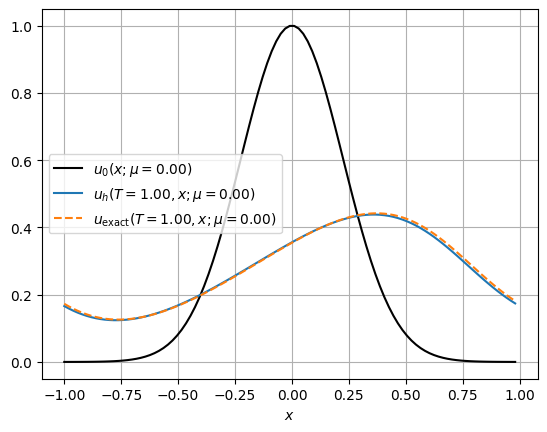

In [4]:
# PDE setup:
T = 1
mu = 0
eps = 1e-1
u_0 = lambda x, mu: np.exp(-10*((x - mu + 1) % 2 - 1)**2)

# Grid setup:
N_h = 100
h = 2/(N_h + 1)
x_h = np.linspace(-1, 1, N_h + 2) # computation grid
N_eval = N_h
x_eval = x_h # evaluation grid

# Solve Galerkin ODE system:
k = 1/eps * h**2/6
start = time.time() 
U_h = solve_galerkin_ODE(k, N_h, T, u_0, mu)
end = time.time()    
print(f'Time (online): {end-start:.5f}s')

# Evalute the approximate solution on the evaluation grid:
I, XEVAL = np.meshgrid(np.arange(N_h + 1), x_eval[:-1])
u_h = Phi(I, XEVAL) @ U_h

# Compute the L-inf error:
u_ex = compute_burgers_reference(N_h + 1, eps, T, lambda x: u_0(x, mu))
error = np.max(np.abs(u_ex - u_h))/np.max(np.abs(u_ex))
print(f'Error (L-inf): {error:.2e}')

# Plot:
plt.figure()
plt.plot(x_eval[:-1], u_0(x_eval[:-1], mu), '-k', label=r'$u_0(x; \mu = %.2f)$' % mu)
plt.plot(x_eval[:-1], u_h, '-', label=r'$u_h(T = %.2f, x; \mu = %.2f)$' % (T, mu))
plt.plot(x_eval[:-1], u_ex, '--', label=r'$u_\mathrm{exact}(T = %.2f, x; \mu = %.2f)$' % (T, mu))
plt.xlabel(r"$x$")
plt.grid()
plt.legend();

Pour le choix de k, un pas de temps plus grand risquerait de rendre l’approximation instable, tandis qu’un pas de temps plus petit ralentirait les calculs sans gain significatif en précision.

## 2.2 Snapshots

Next, we assemble the snapshot matrix at the final time $T$

$$
S = [U_h(T;\mu_1) | \ldots | U_h(T;\mu_n)] \in \R^{(N_h+1)\times n}.
$$

### Exercise

{exercise}
Complete the missing parts.

The $L^\infty$-error should be between $10^{-3}$ and $10^{-4}$.

In [5]:
def compute_snapshots(N_h, n, k, T, u_0, mu):
    """
    Compute a set of solution snapshots using the Galerkin method and forward Euler.

    Parameters
    ----------
    N_h : int
        The number of interior grid points.
    n : int
        The number of parameter samples.
    k : float
        The time-step size.
    T : float
        The final time for the simulation.
    u_0 : function
        The function defining the initial condition.
    mu : np.ndarray
        The vector of parameter values.

    Returns
    -------
    S : np.ndarray
        A matrix of shape (N_h+1, n) where each column is a solution snapshot at the final time.
    """
    
    # Initialize the matrix:
    S = np.zeros((N_h + 1, n))

    # Loop over the parameter values
    for i in range(n):
        S[:, i] = solve_galerkin_ODE(k, N_h, T, u_0, mu[i])
        
    return S

### Validation

In [6]:
# Compute snapshots:
n = 50
mu_val = np.linspace(-0.25, 0.25, n)
start = time.time() 
S = compute_snapshots(N_h, n, k, T, u_0, mu_val)
end = time.time()
print(f'Time (offline): {end-start:.5f}s')

# Compute exact snapshots:
start = time.time() 
S_ex = np.zeros((N_h + 1, n))
for i in range(n):
    S_ex[:, i] = compute_burgers_reference(N_h + 1, eps, T, lambda x: u_0(x, mu_val[i]))

# Compute the L-inf error:
error = np.max(np.abs(S - S_ex))/np.max(np.abs(S_ex))
print(f'Error  (L-inf): {error:.2e}')

Time (offline): 15.43598s
Error  (L-inf): 2.66e-02


## 2.3 Reduced basis

Now, we compute the SVD of $S=U\Sigma V^T$ and set

$$
W = [U_1 | \ldots U_N] \in \R^{(N_h+1)\times N},
$$

where $N$ is chosen such that

$$
\frac{\sum_{j=1}^N\sigma_j^2}{\sum_{j=1}^r\sigma_j^2} \geq 1 - \epsilon^2.
$$

### Exercise

{exercise}
Complete the missing parts (same routine as before).

The singular values should decay to $10^{-16}$ and $N$ should be equal to $7$, corresponding to a singular value around $10^{-5}$. The functions $u_0$ and its projection will not overlap perfectly; why do you think that is?

In [7]:
def compute_reduced_basis(S, epsilon):
    """
    Computes a reduced basis using Singular Value Decomposition (SVD) by selecting the
    first N singular vectors that capture a desired amount of energy.

    Parameters
    ----------
    S : numpy.ndarray
        The input matrix for which the reduced basis is to be computed. It should be of shape (N_h+1, n). 
    epsilon : float
        The energy threshold (0 < epsilon < 1). It determines the fraction of the total energy 
        to be captured by the reduced basis.

    Returns
    -------
    W : numpy.ndarray
        The matrix of the first N singular vectors (reduced basis), with shape (N_h+1, N), where N is the 
        number of singular vectors selected.
    Sigma : numpy.ndarray
        The vector of singular values of S.
    N : int
        The number of singular vectors selected, corresponding to the desired energy threshold.
    
    Notes
    -----
    The function performs an SVD on the input matrix `S`, computes the cumulative energy captured 
    by the singular values, and selects the minimum number of singular vectors that capture at least 
    (1 - epsilon^2) of the total energy.
    """

    # SVD:
    U, Sigma, VT = np.linalg.svd(S, full_matrices=False)

    # Choose N from epsilon:
    total_energy = np.sum(Sigma**2)
    cumulative_energy = np.cumsum(Sigma**2)
    N = np.searchsorted(cumulative_energy / total_energy, 1 - epsilon**2) + 1

    # Select the first N singular vectors:
    W = U[:, :N]

    return W, Sigma, N    

### Validation

7 1.8868336821952494e-05 8.216908644766541e-16


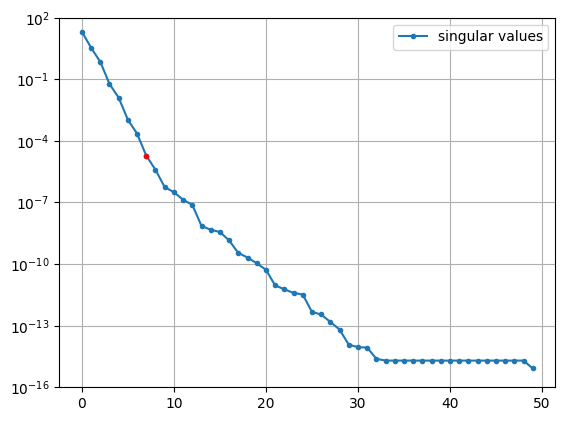

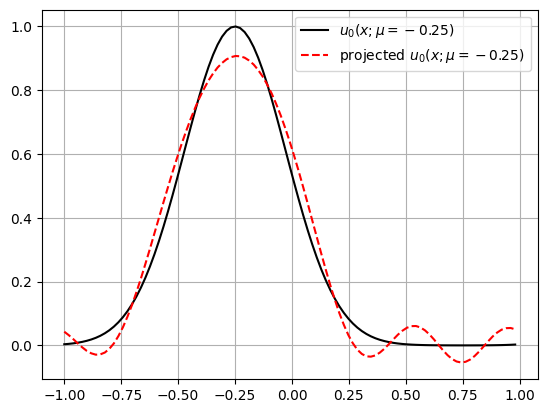

In [8]:
epsilon = 1e-6
W, Sigma, N = compute_reduced_basis(S, epsilon)
print(N, Sigma[N], Sigma[-1])

plt.figure()
plt.semilogy(Sigma, '.-', label="singular values")
plt.semilogy(N, Sigma[N], '.r')
plt.ylim(1e-16, 1e2)
plt.grid()
plt.legend();

v = W @ W.T @ u_0(x_h[:-1], mu_val[0])
plt.figure()
plt.plot(x_h[:-1], u_0(x_h[:-1], mu_val[0]), '-k', label=r'$u_0(x; \mu = %.2f)$' % mu_val[0])
plt.plot(x_h[:-1], v, '--r', label=r'projected $u_0(x; \mu = %.2f)$' % mu_val[0])
plt.grid()
plt.legend();

Les 2 fonctions ne coïncident pas parfaitement car l’espace sur lequel on projette $u_0$ est un sous-espace, généré par une base réduite. Cela entraîne une perte des détails présents dans $u_0$

## 2.4 Reduced Galerkin ODE system

### Exercise (theory)

{exercise}
Write down the reduced Galerking ODE system.

*Hint: Think carefully about the nonlinearity.*

# Reduced Galerkin ODE System

We have

$$
M_h\, U_h'(t;\mu) = -\frac{1}{2}\, K_h\, \bigl( U_h(t;\mu) \odot U_h(t;\mu) \bigr) - \epsilon\, A_h\, U_h(t;\mu)
$$

and in the reduced‐basis method, we use the following approximation:

$$
U_h(t;\mu) \approx W\, U_N(t;\mu)
$$

where $W \in \mathbb{R}^{N_h \times N}$ is the reduced basis matrix and $U_N(t;\mu) \in \mathbb{R}^N$ is the vector of reduced coefficients.

By projecting the system onto the reduced space—multiplying on the left by $W^T$—we obtain:

$$
W^T M_h\, W\, U_N'(t;\mu)
= -\frac{1}{2}\, W^T K_h\, \Bigl( \bigl( W\, U_N(t;\mu) \bigr) \odot \bigl( W\, U_N(t;\mu) \bigr) \Bigr)
\;-\;\epsilon\, W^T A_h\, W\, U_N(t;\mu)
$$

This is exactly the desired Galerkin ODE system.

### Exercise

{exercise}
Complete the missing parts.

The $L^\infty$-error should be at most around $10^{-2}$.

In [9]:
def solve_reduced_galerkin_ODE(k, N_h, T, u_0, mu):
    """
    Solves the reduced Galerkin ODE system using the reduced basis W and forward Euler.

    Parameters
    ----------
    k : float
        The time-step size.
    N_h : int
        The number of interior grid points.
    T : float
        The final time for the simulation.
    u_0 : function
        The function defining the initial condition.
    mu : float
        The parameter for the initial condition.

    Returns
    -------
    U_N : numpy.ndarray
        The solution of the ODE at the final time T in the reduced space, with shape (N,).
    
    Notes
    -----
    - We assume a global or previously defined reduced basis W of shape (N_h+1, N).
    - The time-stepping scheme here is forward Euler in the reduced space, but each step
      uses a solve with M_N to account for the mass matrix. This can be considered
      a "semi-implicit" form if A_h is large or we have a small time-step.
    - We handle the nonlinearity by evaluating (W U_N)^2 in the full space, applying K_h,
      then projecting with W^T.
    """
    W, Sigma, N = compute_reduced_basis(S, epsilon) #On reprend W précédente
    # Grid:
    x_h = np.linspace(-1, 1, N_h + 1)

    # Construct the matrices:
    A_h, K_h, M_h = assemble_matrices(N_h)

    # Construct the reduced matrices:
    A_N = W.T @ A_h @ W
    K_N = None  # K_N n'est pas utilisée dans la version réduite que l'on vient d'obtenir.
    M_N = W.T @ M_h @ W
    # Reduced initial condition:
    U0_full = np.array([u_0(x, mu) for x in x_h])
    U_N = spsolve(M_N, W.T @ (M_h @ U0_full))

    # Time-stepping loop with forward Euler:
    t = 0.0
    while t < T:
        U_sq   = (W @ U_N)**2
        nonlinear = W.T @ (K_h @ U_sq)
        rhs = (M_N @ U_N) - (k/2) * nonlinear - k * 0.1 * (A_N @ U_N)
        U_N = spsolve(M_N, rhs)
        t += k
    return U_N



### Validation

C:\Users\ethan\AppData\Local\Temp\ipykernel_20020\741736955.py:45: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  U_N = spsolve(M_N, W.T @ (M_h @ U0_full))
C:\Users\ethan\AppData\Local\Temp\ipykernel_20020\741736955.py:53: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  U_N = spsolve(M_N, rhs)


Time  (online): 0.44666s
Error  (L-inf): 2.67e-02


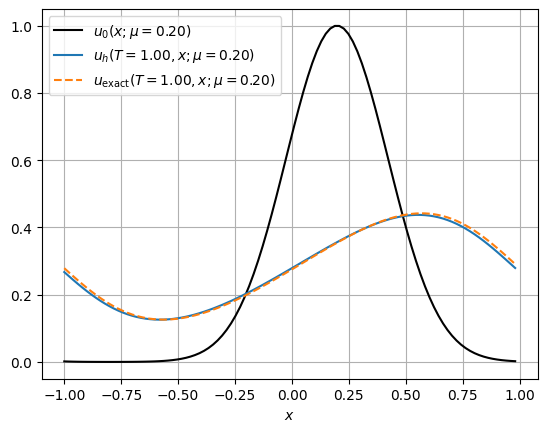

In [10]:
# Solve Galerkin ODE system:
mu_new = mu_val[0] + (mu_val[-1] - mu_val[0]) * np.random.rand()
start = time.time()
U_N = solve_reduced_galerkin_ODE(k, N_h, T, u_0, mu_new)
end = time.time()    
print(f'Time  (online): {end-start:.5f}s')

# Evalute the approximate solution on the evaluation grid:
I, XEVAL = np.meshgrid(np.arange(N_h + 1), x_eval[:-1])
u_h = Phi(I, XEVAL) @ (W @ U_N)

# Compute the L-inf error:
u_ex = compute_burgers_reference(N_h + 1, eps, T, lambda x: u_0(x, mu_new))
error = np.max(np.abs(u_ex - u_h))/np.max(np.abs(u_ex))
print(f'Error  (L-inf): {error:.2e}')

# Plot:
plt.figure()
plt.plot(x_eval[:-1], u_0(x_eval[:-1], mu_new), '-k', label=r'$u_0(x; \mu = %.2f)$' % mu_new)
plt.plot(x_eval[:-1], u_h, '-', label=r'$u_h(T = %.2f, x; \mu = %.2f)$' % (T, mu_new))
plt.plot(x_eval[:-1], u_ex, '--', label=r'$u_\mathrm{exact}(T = %.2f, x; \mu = %.2f)$' % (T, mu_new))
plt.xlabel(r"$x$")
plt.grid()
plt.legend();

# Lecture questions (Chapter 7)

```{exercise}
Prove equation (11).
```

# Démonstration de l'équation (11)

Montrons que
$$
A_N(\mu) = W^T\, A_h(\mu)\, W \quad \text{et} \quad F_N(\mu) = W^T\, F_h(\mu)
$$

### $A_N(\mu)$

En exprimant $\psi_i$ en fonction des $\phi_j$, on a
$$
\psi_i = \sum_{\ell=1}^{N_h} \psi_i(x_\ell)\, \phi_\ell,
$$

Puis par  bilinéarité de $a$ par rapport aux 2 premières variables, on a :
$$
(A_N(\mu))_{ij} = a(\psi_j,\psi_i;\mu) = a\Bigl(\sum_{k=1}^{N_h} \psi_j(x_k)\,\phi_k,\; \sum_{\ell=1}^{N_h} \psi_i(x_\ell)\,\phi_\ell;\mu\Bigr)
= \sum_{k,\ell=1}^{N_h} \psi_j(x_k)\, \psi_i(x_\ell)\, (A_h(\mu))_{k\ell}
$$
D'ou le résultat :
$$
A_N(\mu) = W^T\, A_h(\mu)\, W
$$

### $F_N(\mu)$

De même,
$$
(F_N(\mu))_i = f(\psi_i;\mu) = f\Bigl(\sum_{\ell=1}^{N_h} \psi_i(x_\ell)\,\phi_\ell;\mu\Bigr)
= \sum_{\ell=1}^{N_h} \psi_i(x_\ell)\, (F_h(\mu))_\ell
$$
D'ou le résultat : 
$$
F_N(\mu) = W^T\, F_h(\mu)
$$

```{exercise}
Prove (3), (4), (5), (6), and (11) of Theorem 1.
```

# Preuve du Point 3 du Théorème 1

Montrons que les valeurs singulières non nulles de $A\in\mathbb{R}^{m\times n}$ sont les racines carrées des valeurs propres non nulles de $A^T A$ (et de $AA^T$).

Soit la décomposition en valeurs singulières de $A$ :
$$
A = U\,\Sigma\,V^T,
$$

Calculons :
$$
A^T A = (U\,\Sigma\,V^T)^T (U\,\Sigma\,V^T) = V\,\Sigma^T\,U^T\,U\,\Sigma\,V^T.
$$
Avec $U^T U = I_m$, donc :
$$
A^T A = V\,\Sigma^T\Sigma\,V^T.
$$

or $\Sigma^T \Sigma$ est une matrice diagonaledont les valeurs sur la diagonale princiaple sont $\sigma_1^2, \sigma_2^2, \dots, \sigma_n^2$, les valeurs singulières de $A$, nous avons alors montré que ce sont donc des valeurs propres de $A^T A$ (il suffit de prendrep our vectuer propre une colonne de $V$ car $V$ est orthogonale


Réciproquement, prenons $v\in\mathbb{R}^n$ et $\lambda>0$ tels que
$$
A^T A\,v = \lambda\, v.
$$
Posons $\sigma=\sqrt{\lambda}>0$. Montrons que $v$ est alors un vecteur singulier de $A$ associé à la valeur singulière $\sigma$.

On pose (comme dans la définition du SVD) :
$$
u = \frac{1}{\sigma}A\,v.
$$
On a alors $A\,v = \sigma\, u$ et $A^T\,u = \frac{1}{\sigma}A^T A\,v = \frac{1}{\sigma}\lambda\, v = \sigma\, v$

Donc $(u,v)$ satisfait les définitions de vecteurs singuliers pour $A$ avec la valeur singulière $\sigma$, ce qui conclut le point 3 du théorème 1



# Preuve du Point 4 du Théorème 1

Montrons que :
- Les vecteurs singuliers gauches de $A \in \mathbb{R}^{m\times n}$ sont des vecteurs propres de $AA^T$.
- Les vecteurs singuliers droits de $A$ sont des vecteurs propres de $A^TA$.

Pour $AA^T$:

On a 
$$
AA^T = (U\,\Sigma\,V^T)(U\,\Sigma\,V^T)^T = U\,\Sigma\,\Sigma^T\,U^T.
$$
et comme précédemment, on rappelle que $\Sigma\,\Sigma^T$ est une matrice diagonale de taille $m\times m$ dont les $r$ premières entrées diagonales sont $\sigma_1^2,\dots,\sigma_n^2$ (les autres étant nulles), on obtient
$$
AA^T\,u_i = \sigma_i^2\, u_i \quad \text{pour } i=1,\dots,n.
$$
Les $u_i$ étant les colonnes de $U$

Ainsi, chaque vecteur singulier gauche $u_i$ est bien un vecteur propre de $AA^T$, associé à la valeur propre $\sigma_i^2$.

Pour $A^TA$:

Comme précédemment,
$$
A^TA = V\,\Sigma^T\,\Sigma\,V^T.
$$
Avec, $\Sigma^T\,\Sigma$ définie comme précédemment. Ainsi,
$$
A^TA\,v_i = \sigma_i^2\, v_i \quad \text{pour } i=1,\dots,n.
$$
Les vecteurs singuliers droits $v_i$ sont donc des vecteurs propres de $A^TA$, associés à la valeur propre $\sigma_i^2$, ce qui conclut le point 4 du théorème

# Preuve du Point 5 du Théorème 1

Montrons que : 
- Le rang de $A$ est $r$, le nombre de valeurs singulières non nulles.
- $\operatorname{range}(A) = \operatorname{span}\{u_1,\dots,u_r\}$, où les $u_i$ sont les vecteurs singuliers gauches associés aux valeurs singulières non nulles.
- $\operatorname{null}(A) = \operatorname{span}\{v_{r+1},\dots,v_n\}$, où les $v_i$ (pour $i=r+1,\dots,n$) sont les vecteurs singuliers droits associés aux valeurs nulles.



## Rang de $A$ :

La matrice $\Sigma$ est diagonale avec les valeurs singulières $\sigma_1,\dots,\sigma_{r}$. Par définition, le rang de $A$ est le nombre de ces valeurs singulières strictement positives. Soit ce nombre $r$. Ainsi, $\operatorname{rank}(A)=r$.

## $\operatorname{range}(A)$ : 

Soit $y \in \operatorname{range}(A)$. Il existe $x \in \mathbb{R}^n$ tel que 
$$
y = Ax = U\,\Sigma\,V^T x.
$$
Posons $z = V^T x$. Alors,
$$
y = U\,\Sigma\,z.
$$
Et on a :
$$
\Sigma\,z = \begin{pmatrix}
\sigma_1 z_1 \\
\sigma_2 z_2 \\
\vdots \\
\sigma_r z_r \\
0 \\
\vdots \\
0
\end{pmatrix}.
$$
D'où : 
$$
y = \sum_{i=1}^{r} \sigma_i z_i\, u_i,
$$
Réciproquement, $A\,v_i = \sigma_i\, u_i,$ ce qui montre que $u_i \in \operatorname{range}(A)$. Ainsi,
$$
\operatorname{range}(A) = \operatorname{span}\{u_1,\dots,u_r\}.
$$

## $\operatorname{null}(A)$ :

Soit $x \in \operatorname{null}(A)$, on a :
$$
Ax = U\,\Sigma\,V^T x = 0.
$$
Or $U$ est inversible car orthogonale donc :
$$
\Sigma\,V^T x = 0.
$$
Avec $z = V^T x$ comme précédemment, on a nécessairement, du fait que $\sigma_1,\dots,\sigma_r > 0$ : 
$$
z_1 = z_2 = \cdots = z_r = 0.
$$
Alors,
$$
z = \begin{pmatrix} 0 \\ \vdots \\ 0 \\ z_{r+1} \\ \vdots \\ z_n \end{pmatrix}.
$$
Or $x = V\,z$ car $V$ est orthogonale, donc : 
$$
x \in \operatorname{span}\{v_{r+1},\dots,v_n\}.
$$
Réciproquement, pour des réels quelconques $\lambda_{r+1},\dots,\lambda_n$, on a :
$$
Ax = \sum_{i=r+1}^{n} \lambda_i\, A\,v_i = \sum_{i=r+1}^{n} \lambda_i\, \sigma_i\, u_i = 0,
$$
car $\sigma_i=0$ lorsque $i>r$. On a donc :
$$
\operatorname{null}(A) = \operatorname{span}\{v_{r+1},\dots,v_n\}.
$$

# Preuve du Point 6 du Théorème 1

Montrons que :

- La norme spectrale de $A$, notée $\|A\|_2$, est égale à la plus grande valeur singulière de $A$, c'est-à-dire
   $$
   \|A\|_2 = \sigma_1.
   $$

- La norme de Frobenius de $A$, notée $\|A\|_F$, est donnée par
   $$
   \|A\|_F = \sqrt{\sum_{j=1}^{r} \sigma_j^2},
   $$
   où $r$ est le rang de $A$ (c'est-à-dire le nombre de valeurs singulières strictement positives).

- $\|A\|_2 \le \|A\|_F$, avec égalité si et seulement si $A$ est de rang $0$ ou $1$.

## $\|A\|_2 $

Par définition,
$$
\|A\|_2 = \max_{x\neq 0}\frac{\|Ax\|_2}{\|x\|_2}.
$$

$U$ et $V$ étant orthogonales, on a :
$$
\|A\|_2 = \|\Sigma\|_2,
$$
En prenant $\sigma_1\ge \sigma_2\ge \cdots \ge \sigma_r>0$ , on obtient que :
$$
\|A\|_2 = \|\Sigma\|_2 = \sigma_1.
$$

## $ \|A\|_F $

Par définition :
$$
\|A\|_F = \sqrt{\sum_{i,j} a_{ij}^2}.
$$
De plus, la norme de Frobenius est également invariante par transformation orthogonale, on a :
$$
\|A\|_F = \|\Sigma\|_F = \sqrt{\sigma_1^2 + \sigma_2^2 + \cdots + \sigma_r^2}.
$$

## $\|A\|_2 \le \|A\|_F$

Cela découle du fait que 
$$
\sigma_1^2 \le \sum_{j=1}^{r} \sigma_j^2,
$$

d'ou, en passant à la racine : 

$$
\|A\|_2 \le \|A\|_F.
$$

On retrouve évidémment l'égalité lorsque la dimension vaut 1 ou 0 car on a une somme avec un seul terme, ce qui achève la preuve.


# Preuve du Point 11 du Théorème 1

Montrons que pour le problème des moindres carrés, $x = V\, \Sigma^{-1}\, U^T\, b$ est la solution des équations normales 
$$
A^T A\, x = A^T b
$$

On pose
$$
x = V\, y, \quad \text{, } y\in \mathbb{R}^n.
$$
Les équations normales deviennent :
$$
A^T A\, V\, y = A^T b.
$$
En utilisant $A^T A = V\, \Sigma^T\, \Sigma\, V^T$, on a
$$
V\, (\Sigma^T\, \Sigma)\, V^T\, V\, y = V\, (\Sigma^T\, \Sigma)\, y = A^T b.
$$
De plus, on a aussi
$$
A^T b = (U\, \Sigma\, V^T)^T b = V\, \Sigma^T\, U^T\, b.
$$

Ainsi, en multipliant à gauche par $V^T$, on a :
$$
\Sigma^T\, \Sigma\, y = \Sigma^T\, U^T\, b.
$$
Enfin, l'énoncé du point 11 nous suggère que $\Sigma$ est inversible car il utilise son inverse, on utilise donc cela et on a :
$$
y = \Sigma^{-1}\, U^T\, b
$$

En revenant à $x = V\, y$, nous avons
$$
x = V\, \Sigma^{-1}\, U^T\, b.
$$
Ce qui est le résultat souhaité.